# Раздел 1. Исследовательский анализ данных 

## Описание данных:
1) data_arc.csv — данные об электродах;

2) data_bulk.csv — данные о подаче сыпучих материалов (объём);

3) data_bulk_time.csv — данные о подаче сыпучих материалов (время);

4) data_gas.csv — данные о продувке сплава газом;

5) data_temp.csv — результаты измерения температуры;

6) data_wire.csv — данные о проволочных материалах (объём);

7) data_wire_time.csv — данные о проволочных материалах (время);

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

## Исследование данных об электродах

In [2]:
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')

In [3]:
display(df_arc.head(15))
df_arc.info()
df_arc.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [4]:
print('Явные выбросы:')
display(df_arc[df_arc['Реактивная мощность'] < 0])

Явные выбросы:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [5]:
df_arc_group = df_arc.groupby('key')['key'].count()
print('Количество итераций:')
display(df_arc_group)
print('Медиана количества итераций:', df_arc_group.median())
print('Среднее количества итераций:', df_arc_group.mean())

Количество итераций:


key
1       5
2       4
3       5
4       4
5       4
       ..
3237    5
3238    3
3239    8
3240    5
3241    5
Name: key, Length: 3214, dtype: int64

Медиана количества итераций: 4.0
Среднее количества итераций: 4.628500311138768


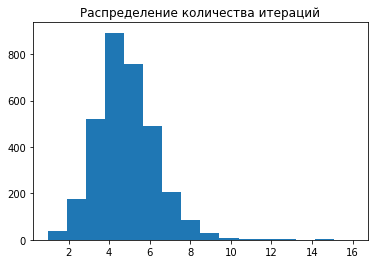

In [6]:
plt.hist(df_arc_group, bins=16)
plt.title('Распределение количества итераций')
plt.show()

In [7]:
print('Пример одной партии:')
display(df_arc[df_arc['key'] == 123])

Пример одной партии:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
561,123,2019-05-07 21:28:42,2019-05-07 21:36:31,1.845214,1.419651
562,123,2019-05-07 21:41:07,2019-05-07 21:43:04,0.478513,0.369528
563,123,2019-05-07 21:46:51,2019-05-07 21:50:53,1.023498,0.751249
564,123,2019-05-07 22:01:25,2019-05-07 22:03:09,0.436658,0.312079


### Выводы
**Был проведен исследовательский анализ данных об электродах. Был найден один явный выброс с большим отрицательным значением реактивной мощности. Медиана количества итераций равна 4, распределение количества итераций можно назвать нормальным, если не обращать внимание на выбросы, где n > 9. В нашем распоряжении данные, в которых количество партий = 3214. Пропущенных значений в этом наборе данных нет.**

## Исследование добавок

In [8]:
df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

In [9]:
display(df_bulk)
df_bulk.info()
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [10]:
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
display(df_bulk_time)
df_bulk_time.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


### Выводы 
**В данных о добавках присутствует 15 колонок, каждая из которых соответствует конкретной добавке. Сыпучие материалы добавляют всегда один раз в пределах одной партии (но некоторые из них в разное время). Есть популярные добавки (например №3, 4, 12, 14, 15), а также не очень популярные (№2, 5, 7, 8, 9, 13).**

## Исследование данных о подаче газа

In [11]:
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
display(df_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


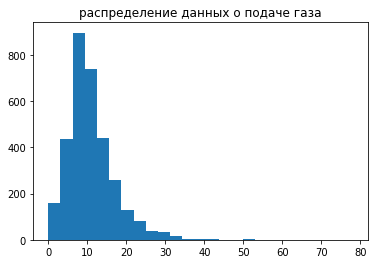

In [12]:
plt.hist(df_gas['Газ 1'], bins=25)
plt.title('распределение данных о подаче газа')
plt.show()

### Выводы: 
**В данных о подаче инертного газа присутствуют 3239 строк. Данные распределены практически нормально, если не учитывать выбросы, где значения больше 30.**

## Исследование данных о температуре

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


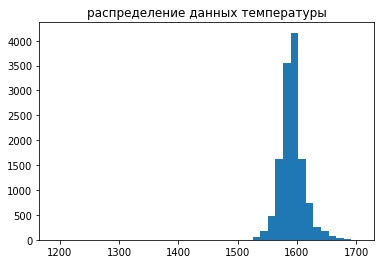

In [13]:
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
display(df_temp.head(16))
display(df_temp.describe())
df_temp.info()

plt.hist(df_temp['Температура'], bins = 40)
plt.title('распределение данных температуры')
plt.show()

### Выводы
**В данных с температурой присутствуют выбросы (значения, которые меньше 1500). Пропущены значения примерно в 20 % исходных данных.**

## Исследование данных о проволочных материалах

In [14]:
df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
display(df_wire)
df_wire.info()


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [15]:
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
display(df_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Выводы 
**Проволочные материалы добавляют только один раз в пределах одной партии. В предоставленных данных имеются популярные добавки (№1, 2) и не очень популярные (№3-9). Всего в нашем распоряжении информация о 3080 партиях.**

## Сопоставление времени добавления сыпучих и проволочных материалов с промежутками нагрева стали (итерациями)

In [16]:
# перевод данных в нужный формат даты

columns_wire = list(df_wire_time)
columns_wire.remove('key')

for wire in columns_wire:
    df_wire_time[wire] = pd.to_datetime(df_wire_time[wire], format='%Y-%m-%d %H:%M:%S')
    
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null datetime64[ns]
Wire 2    1079 non-null datetime64[ns]
Wire 3    63 non-null datetime64[ns]
Wire 4    14 non-null datetime64[ns]
Wire 5    1 non-null datetime64[ns]
Wire 6    73 non-null datetime64[ns]
Wire 7    11 non-null datetime64[ns]
Wire 8    19 non-null datetime64[ns]
Wire 9    29 non-null datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [17]:
df_new = df_arc.copy()
df_new['Bulk'] = 0
df_new['wire'] = 0

# перевод данных в нужный формат
df_merge_new_bulk_time = pd.merge(df_new, df_bulk_time, on='key')
df_merge_new_bulk_time['Начало нагрева дугой'] = pd.to_datetime(df_merge_new_bulk_time['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_merge_new_bulk_time['Конец нагрева дугой'] = pd.to_datetime(df_merge_new_bulk_time['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')


columns_df_bulk_time = list(df_bulk_time)
columns_df_bulk_time.remove('key')

for bulk in columns_df_bulk_time:
    df_merge_new_bulk_time[bulk] = pd.to_datetime(df_merge_new_bulk_time[bulk], format='%Y-%m-%d %H:%M:%S')

In [18]:
#разметка итараций: ставим "1" в той строке, в момент времени которой происходила добавка сыпучих материалов

for i in range(len(df_merge_new_bulk_time)):
    for bulk in columns_df_bulk_time:
        if df_merge_new_bulk_time.loc[i, 'Начало нагрева дугой'] <= df_merge_new_bulk_time.loc[i, bulk] <= df_merge_new_bulk_time.loc[i, 'Конец нагрева дугой']:
            df_merge_new_bulk_time.loc[i, 'Bulk'] = 1
        
    
columns_df_merge_new_bulk_time = list(df_merge_new_bulk_time)
display(df_merge_new_bulk_time.head(14))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Bulk,wire,Bulk 1,Bulk 2,Bulk 3,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1,0,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0,0,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0,0,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1,0,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0,0,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0,0,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1,0,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,1,0,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0,0,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,1,0,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40


In [19]:
#соединяем таблицы и снова размечаем итерации: ставим "1" в тех строках итераций, после которых были добавлены проволочные материалы

df_merge_bulk_wire_time = pd.merge(df_merge_new_bulk_time, df_wire_time, on='key')
display(df_merge_bulk_wire_time.head(10))

for i in range(len(df_merge_bulk_wire_time)-1):
    for wire in columns_wire:
        if df_merge_bulk_wire_time.loc[i, 'Конец нагрева дугой'] <= df_merge_bulk_wire_time.loc[i, wire] <= df_merge_bulk_wire_time.loc[i+1, 'Начало нагрева дугой']:
            df_merge_bulk_wire_time.loc[i, 'wire'] = 1

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Bulk,wire,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1,0,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0,0,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0,0,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1,0,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0,0,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0,0,NaT,NaT,NaT,...,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1,0,NaT,NaT,NaT,...,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,1,0,NaT,NaT,NaT,...,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0,0,NaT,NaT,NaT,...,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,1,0,NaT,NaT,NaT,...,2019-05-03 12:09:40,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [20]:
display(df_merge_bulk_wire_time.head(10))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Bulk,wire,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1,0,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0,1,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0,0,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1,0,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0,0,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0,0,NaT,NaT,NaT,...,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1,1,NaT,NaT,NaT,...,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,1,0,NaT,NaT,NaT,...,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0,0,NaT,NaT,NaT,...,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,1,1,NaT,NaT,NaT,...,2019-05-03 12:09:40,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [21]:
columns_df_merge_bulk_wire_time = list(df_merge_bulk_wire_time)
print(columns_df_merge_bulk_wire_time)

['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность', 'Bulk', 'wire', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']


In [22]:
new_col = ['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность', 'Bulk', 'wire']
df_cut = df_merge_bulk_wire_time[new_col]
df_cut['Время нагрева'] = df_cut['Конец нагрева дугой'] - df_cut['Начало нагрева дугой']
display(df_cut.head(14))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Bulk,wire,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1,0,00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0,1,00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0,0,00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1,0,00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0,0,00:02:28
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0,0,00:02:17
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1,1,00:05:38
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,1,0,00:02:06
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0,0,00:03:30
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,1,1,00:04:40


### Выводы 
**Таблица df_cut содержит два дополнительных столбца - Bulk и wire. "1" в Bulk означает факт добавления сыпучих материалов в конкретной итерации отдельной партии. "1" в wire означает факт добавления проволочных материалов после той итерации, в которой она обозначена, т.к. проволочные материалы добавляют между итерациями нагрева. Проанализировав финальную таблицу df_cut остается не совсем понятным, на основе каких данных принимают решение о добавлении сыпучих, или проволочных материалов.**

# Раздел 2. Код решения 

## Предобработка данных по температуре

In [23]:
df_temp.columns = ['key', 'time', 'temp']
df_temp = df_temp.dropna()
#df_temp = df_temp[(df_temp['temp'] > 1550) & (df_temp['temp'] < 1630)]

df_temp_count = df_temp.groupby('key')['temp'].count().reset_index()
df_temp_count.columns = ['key', 'temp_count']
df_temp_count = df_temp_count[df_temp_count['temp_count'] > 1]

dt_temp_last = df_temp.groupby('key')['temp'].last().reset_index()
dt_temp_last.columns = ['key', 'temp_last']

df_temp_first = df_temp.groupby('key')['temp'].first().reset_index()
df_temp_first.columns = ['key', 'temp_first']

df_temp_merge = pd.merge(df_temp_count, dt_temp_last, on='key')
df_temp_merge_final = pd.merge(df_temp_merge, df_temp_first, on='key')
display(df_temp_merge_final)

,key,temp_count,temp_last,temp_first
0,1,5,1613.0,1571.0
1,2,6,1602.0,1581.0
2,3,5,1599.0,1596.0
3,4,3,1625.0,1601.0
4,5,2,1602.0,1576.0
...,...,...,...,...
2470,2495,3,1591.0,1570.0
2471,2496,4,1591.0,1554.0
2472,2497,2,1589.0,1571.0
2473,2498,5,1594.0,1591.0


### Выводы
**Первым делом в данных с температурой удалили пропущенные значения, т.к. заполнять их нечем и это не совсем корректно. В таблицу df_temp_merge_final попали следующие значения: количество замеров температуры в пределах одной партии, последний и первый замер температуры в рамках одной партии.**

## Предобработка данных по газу и добавкам

In [24]:
df_bulk = df_bulk.fillna(0)
df_bulk.columns = ['key', 'Bulk_1', 'Bulk_2', 'Bulk_3', 'Bulk_4', 'Bulk_5', 'Bulk_6',
       'Bulk_7', 'Bulk_8', 'Bulk_9', 'Bulk_10', 'Bulk_11', 'Bulk_12',
       'Bulk_13', 'Bulk_14', 'Bulk_15']

df_wire = df_wire.fillna(0)
df_wire.columns = ['key', 'Wire_1', 'Wire_2', 'Wire_3', 'Wire_4', 'Wire_5', 'Wire_6',
       'Wire_7', 'Wire_8', 'Wire_9']

df_gas.columns = ['key', 'gas']

df_bulk_wire = pd.merge(df_bulk, df_wire, on='key')
df_bulk_wire_gas = pd.merge(df_bulk_wire, df_gas, on='key')

display(df_bulk_wire_gas)

,key,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,...,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9,gas
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.543905
3019,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.745669
3020,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,...,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.023518
3021,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,...,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.863103


### Выводы
**В данных по газу и добавкам заменили пропущенный значения на "0". Далее были переименованны столбцы для последующей обработки.**

## Предобработка данных по мощности и количеству добавлений примесей в пределах одной партии

Корреляция активной и реактивной мощностей [[1.         0.96161956]
 [0.96161956 1.        ]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


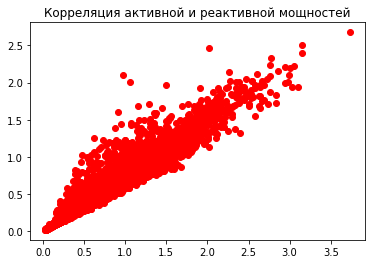

In [25]:
df_cut.columns = ['key', 'heat_start', 'heat_finish',
       'active_p', 'reactive_p', 'bulk_count', 'wire_count',
       'time_ms']
df_cut['time_s'] = df_cut['time_ms'].astype('timedelta64[s]')
df_cut = df_cut[(df_cut['active_p'] > 0) & (df_cut['reactive_p'] > 0)]
#df_cut['energy'] = (df_cut['active_p'] + df_cut['reactive_p']) * df_cut['time_s']

coef = np.corrcoef(df_cut['active_p'], df_cut['reactive_p'])
print('Корреляция активной и реактивной мощностей', coef)
plt.plot(df_cut['active_p'], df_cut['reactive_p'], 'ro')
plt.title('Корреляция активной и реактивной мощностей')
plt.show()

df_cut['energy'] = df_cut['active_p'] * df_cut['time_s']
df_cut_prefinal = df_cut[['key', 'bulk_count', 'wire_count', 'energy']]

In [26]:
df_cut_bulk = df_cut_prefinal.groupby('key')['bulk_count'].sum().reset_index()
df_cut_wire = df_cut_prefinal.groupby('key')['wire_count'].sum().reset_index()
df_cut_energy = df_cut_prefinal.groupby('key')['energy'].sum().reset_index()

df_cut_bulk_wire = pd.merge(df_cut_bulk, df_cut_wire, on='key')
df_cut_bulk_wire_energy = pd.merge(df_cut_bulk_wire, df_cut_energy, on='key')
df_cut_bulk_wire_energy

,key,bulk_count,wire_count,energy
0,1,2,1,1207.804249
1,2,2,1,733.816470
2,3,1,1,443.583327
3,4,2,1,670.663327
4,5,2,2,997.496095
...,...,...,...,...
3019,3237,2,1,777.993447
3020,3238,2,1,432.849310
3021,3239,2,1,844.977151
3022,3240,2,1,554.283211


### Выводы 
**В таблицу df_cut_bulk_wire_energy попали следующие значения: количество различных значений времени, в момент которых в пределах одной партии добавляли разные примеси (bulk_count - сыпучие, wire_count- проволочные); суммарная энергия, затраченная на нагрев стали за одну партию, посчитанная через перемножение активной мощности и времени, т.к. активная и реактивная мощности коррелируют с коэффициентом = 0,96.**

## Создание финальной таблицы данных

In [27]:
df_merge_temp_bulk_wire_energy = pd.merge(df_cut_bulk_wire_energy, df_temp_merge_final, on='key')
df_final = pd.merge(df_merge_temp_bulk_wire_energy, df_bulk_wire_gas, on='key')
df_final = df_final.drop(['key'], axis=1)
df_final

,bulk_count,wire_count,energy,temp_count,temp_last,temp_first,Bulk_1,Bulk_2,Bulk_3,Bulk_4,...,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9,gas
0,2,1,1207.804249,5,1613.0,1571.0,0.0,0.0,0.0,43.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1,733.816470,6,1602.0,1581.0,0.0,0.0,0.0,73.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,1,1,443.583327,5,1599.0,1596.0,0.0,0.0,0.0,34.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,2,1,670.663327,3,1625.0,1601.0,0.0,0.0,0.0,81.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,2,2,997.496095,2,1602.0,1576.0,0.0,0.0,0.0,78.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2,1,626.167357,3,1591.0,1570.0,0.0,0.0,21.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2325,2,1,727.868032,4,1591.0,1554.0,0.0,0.0,0.0,63.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2326,2,1,427.535518,2,1589.0,1571.0,0.0,0.0,0.0,85.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2327,2,1,629.928649,5,1594.0,1591.0,0.0,0.0,90.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


### Выводы
**Финальная таблица с данными содержит информацию о 2329 партиях. Каждая строка таблицы  соответствует одной партии. Все признаки в финальной таблице были объединены из всех предыдущих пунктов по предобработке данных.**

## Разделение данных на выборки

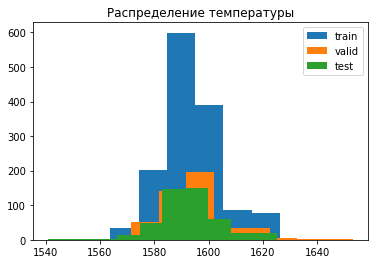

In [28]:
features = df_final.drop(['temp_last'], axis = 1)
target = df_final['temp_last']

features_train_val, features_test, target_train_val, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345) 

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_val, target_train_val, test_size=0.25, random_state=12345)

plt.hist(target_train, label = 'train')
plt.hist(target_valid, label = 'valid')
plt.hist(target_test, label = 'test')
plt.legend()
plt.title('Распределение температуры')
plt.show()

### Выводы 
**Для последующего обучения разных моделей были принято решения разделить исходные данные на тренировочную, валидационную и тестовую выборки в соотношении 3:1:1 соответственно.**

## CatBoostRegressor

In [29]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(50, 501, 50):
    for depth in range (1, 11):
        model = CatBoostRegressor(max_depth = depth, n_estimators = est, verbose = False)
        score = cross_val_score(model, features_train_val, target_train_val, 
                                cv = 5, scoring = make_scorer(mean_absolute_error), verbose = False)
        mean_score = score.mean()
        print('est =', est, 'depth =', depth, 'MAE =', mean_score)
        if mean_score < best_result:
            best_result = mean_score
            best_est = est
            best_depth = depth
    
print('best model with MAE =', best_result, 'best_est =', best_est, 'best_depth =', best_depth)

est = 50 depth = 1 MAE = 7.59838118855901
est = 50 depth = 2 MAE = 7.18628311843017
est = 50 depth = 3 MAE = 7.01762725742164
est = 50 depth = 4 MAE = 6.860347714488862
est = 50 depth = 5 MAE = 6.778764525603589
est = 50 depth = 6 MAE = 6.732518469896187
est = 50 depth = 7 MAE = 6.716237780154678
est = 50 depth = 8 MAE = 6.695955893058931
est = 50 depth = 9 MAE = 6.732705160968163
est = 50 depth = 10 MAE = 6.767088836875392
est = 100 depth = 1 MAE = 7.307188071241741
est = 100 depth = 2 MAE = 6.803092860033656
est = 100 depth = 3 MAE = 6.626623063439974
est = 100 depth = 4 MAE = 6.498673297693264
est = 100 depth = 5 MAE = 6.4118734665336605
est = 100 depth = 6 MAE = 6.380646659731629
est = 100 depth = 7 MAE = 6.353506096340615
est = 100 depth = 8 MAE = 6.319847386308925
est = 100 depth = 9 MAE = 6.341940242684492
est = 100 depth = 10 MAE = 6.391847907056148
est = 150 depth = 1 MAE = 7.092376314714744
est = 150 depth = 2 MAE = 6.577534125695652
est = 150 depth = 3 MAE = 6.42154199850347

In [30]:
model = CatBoostRegressor(max_depth = 8, n_estimators = 500)
model.fit(features_train_val, target_train_val, verbose=False)
prediction = model.predict(features_test)
score = mean_absolute_error(target_test, prediction)
print('MAE =', score)
print('R2 =', r2_score(target_test, prediction))

MAE = 5.9417233590507825
R2 = 0.44008423735554514


### Выводы 
**Модель CatBoostRegressor показала наилучший результат при глубине дерева = 8 и количесте деревьев = 500. Средняя абсолютная ошибка на тестовой выборке получилась = 5.94**

### Гистограмма "важных" признаков для CatBoostRegressor

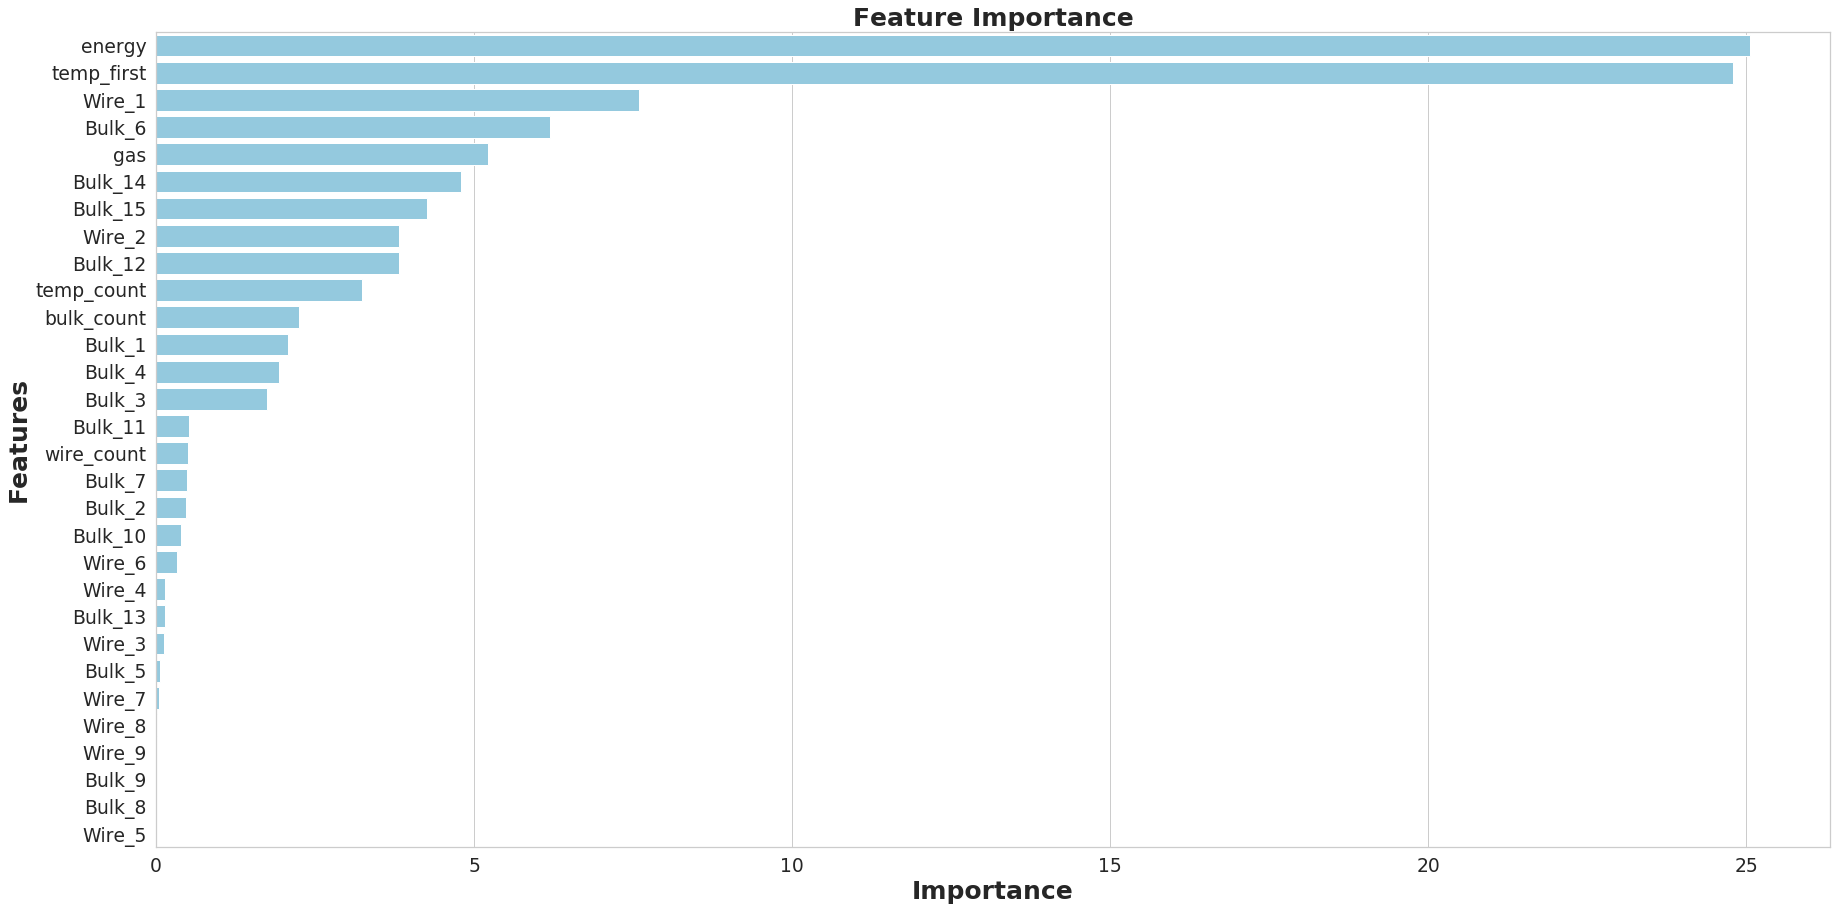

None

In [31]:
feats = {}
for feature, importance in zip(features.columns, model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())

#отберем 10 самых ненужных фичей по версии CatBoost (для дальнейшего использования в линейной регрессии)
importances_last = importances.sort_values(by = 'Gini-Importance').head(10)

### Выводы 
**В данном разделе были обнаружены признаки, которые модель CatBoostRegressor посчитала малоинформативными. Эту информацию мы используем позже при обучении линейной регрессии для улучшения рассматриваемой метрики качества.**

## RandomForestRegressor

In [32]:
rfr = RandomForestRegressor()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 20)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 15)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 15)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfr, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 1, 
                        random_state=12345)
rs.fit(features_train_val, target_train_val)
rs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.0min finished


{'n_estimators': 857,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 14,
 'bootstrap': False}

In [33]:
model = RandomForestRegressor(n_estimators = 857, min_samples_split = 12, min_samples_leaf = 2, 
                              max_features = 'log2', max_depth = 14, bootstrap = False)
model.fit(features_train_val, target_train_val)
prediction = model.predict(features_test)
score = mean_absolute_error(target_test, prediction)
print('MAE =', score)
print('R2 =', r2_score(target_test, prediction))


MAE = 6.445511579119535
R2 = 0.3884451066505654


### Выводы 
**С помощью метода RandomizedSearchCV были найдены оптимальные гиперпараметры модели RandomForestRegressor. На этих параметрах была обучена и проверена модель. На тестовой выборке получилось добиться МАЕ = 6.47**

## LinearRegression

In [34]:
warnings.filterwarnings('ignore')

features_train_val = features_train_val.drop(list(importances_last['Features']), axis = 1)
features_test = features_test.drop(list(importances_last['Features']), axis = 1)
numeric = features_train_val.columns
scaler= StandardScaler()
scaler.fit(features_train_val[numeric]) 
features_train_val[numeric] = scaler.transform(features_train_val[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

model = LinearRegression()
model.fit(features_train_val, target_train_val)
prediction = model.predict(features_test)
score = mean_absolute_error(target_test, prediction)
print('MAE =', score)
print('R2 =', r2_score(target_test, prediction))


MAE = 6.520189552769494
R2 = 0.33339393065767464


### Выводы 
**В этом разделе была обучена модель линейной регрессии на предварительно нормированных данных при помощи метода StandardScaler. Количество признаков было сокращено (отброшены 10 самых неинформативных признаков по версии CatBoost-a). Метрика МАЕ на тестовой выборке получилась = 6.52**

## Общий вывод 
**В ходе выполнения данной работы был проведен исследовательский анализ данных, в результате которого были обнаружены выбросы в данных, а также пропущенные значения. Для дальнейшего обучения моделей было создано несколько дополнительных признаков: количество замеров температуры, количество добавлений примесей в разные промежутки времени, энергия (затраченная на нагрев стали в пределах одной партии). Далее были обучены несколько моделей, среди которых можно выделить CatBoostRegressor. С ее помощью получилось добиться метрики МАЕ на тестовой выборке = 5.94. Итоговая таблица представлена ниже:**

In [35]:
final_df = pd.DataFrame({'MAE' : [5.94, 6.47, 6.52]})
final_df.index = ['CatBoostRegressor', 'RandomForestRegressor', 'LinearRegression']
display(final_df)

,MAE
CatBoostRegressor,5.94
RandomForestRegressor,6.47
LinearRegression,6.52


# Раздел 3. Отчет по решению

**В ходе выполнения данной работы было решено, что будет являться таргетом (последняя измеренная температура) в пределах каждой итерации. Далее была проведена предобработка данных (удалены записи о замерах температуры, в которых не было заполнено само значение этой температуры, а также те итерации, в которых был всего один замер температуры).  Были удалены данные с аномалиями (например те, где мощность была отрицательным значением). Пропущенные значения по добавлению сыпучих и проволочных материалов были заменены на "0". Из-за высокой корреляции активной и реактивной мощностей (0.96) для дальнейшего подсчета затраченной энергии была выбрана первая из них. Были добавлены новые признаки - количество замеров температуры, количество (разных по времени) моментов добавления сыпучих и проволочных материалов. В результате была получена сводная таблица данных, каждая запись которой представлет собой информацию об одной итерации.**

In [36]:
df_final

,bulk_count,wire_count,energy,temp_count,temp_last,temp_first,Bulk_1,Bulk_2,Bulk_3,Bulk_4,...,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9,gas
0,2,1,1207.804249,5,1613.0,1571.0,0.0,0.0,0.0,43.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1,733.816470,6,1602.0,1581.0,0.0,0.0,0.0,73.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,1,1,443.583327,5,1599.0,1596.0,0.0,0.0,0.0,34.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,2,1,670.663327,3,1625.0,1601.0,0.0,0.0,0.0,81.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,2,2,997.496095,2,1602.0,1576.0,0.0,0.0,0.0,78.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2,1,626.167357,3,1591.0,1570.0,0.0,0.0,21.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2325,2,1,727.868032,4,1591.0,1554.0,0.0,0.0,0.0,63.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2326,2,1,427.535518,2,1589.0,1571.0,0.0,0.0,0.0,85.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2327,2,1,629.928649,5,1594.0,1591.0,0.0,0.0,90.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


**В ходе выполнения работы самым трудным было получить метрику МАЕ на тестовой выборке меньше 6. Необходимое значение было получено путем перебора некоторых гиперпараметров (глубины и количества деревьев) в модели CatBoostRegressor. Ниже предлагаю посмотреть на те признаки, которые модель посчитала самыми важными:**

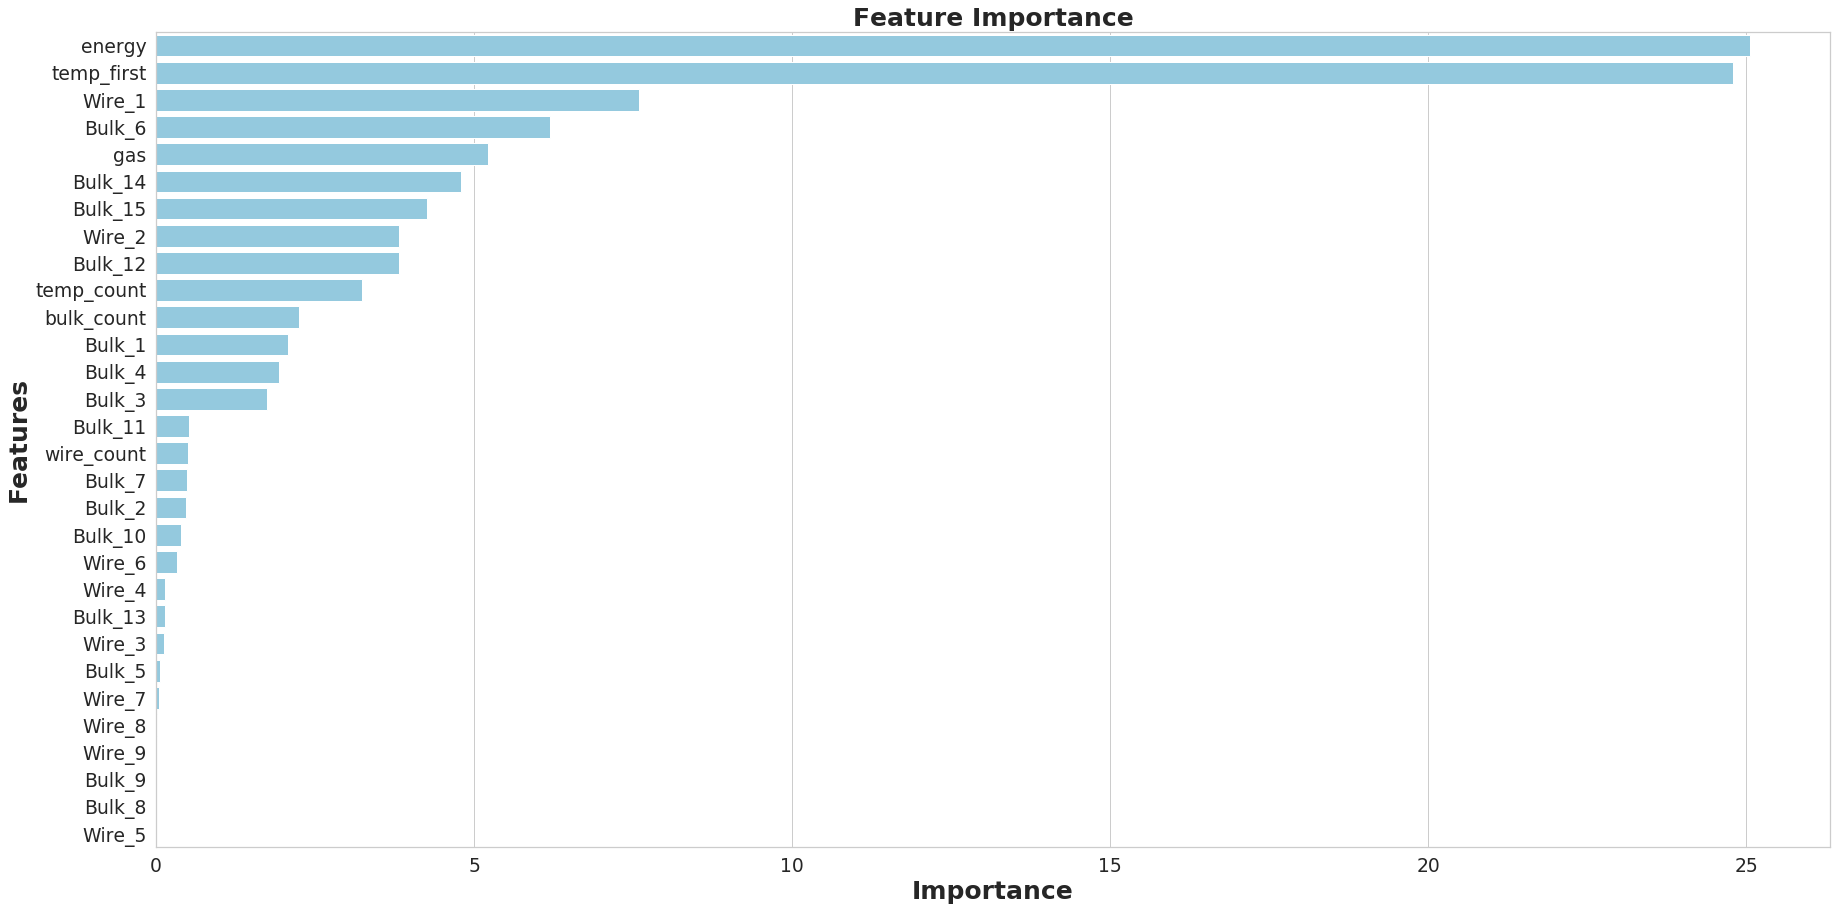

None

In [37]:
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())

**В проекте были обучены несколько моделей машинного обучения (RandomForestRegressor, LinearRegression, CatBoostRegressor). Гиперпараметры RandomForestRegressor подбирались при помощи метода RandomizedSearchCV (случайного поиска). Для обучения LinearRegression использовались признаки, которые CatBoostRegressor посчитала самыми важными (были отброшены 10 самых ненужных признаков). В итоге лучшую метрику МАЕ = 5,94 удалось получить на CatBoostRegressor с глубиной дерева = 8 и количеством деревьев = 500.**

In [38]:
display(final_df)

,MAE
CatBoostRegressor,5.94
RandomForestRegressor,6.47
LinearRegression,6.52
